## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import itertools

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# Enable GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_p=1e-4, l2_p=1e-8, drp_ratio=0.2, BN=True):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_p, l2=l2_p))(input_layer)
            if BN == True:
                x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1),
                                  kernel_regularizer=l1_l2(l1=l1_p, l2=l2_p))(x)
            if BN == True:
                x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
REGULAR = [(1e-4, 1e-8), (1e-8, 1e-12)]
DROPOUT_RATE = [0.1, 0.25]
BN = [True, False]

In [10]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for (l1_p, l2_p), drp, bn in itertools.product(REGULAR, DROPOUT_RATE, BN):
    keras.backend.clear_session     # 把舊的 Graph 清掉
    print(f"l1:{l1_p} l2:{l2_p} dropout rate:{drp} BN:{bn}")
    model = build_mlp(input_shape=x_train.shape[1:], l1_p=l1_p, l2_p=l2_p, drp_ratio=drp, BN=bn)
    model.summary()    

    opt = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer=opt)
    model.fit(x_train, y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = f"l1:{l1_p} l2:{l2_p} dropout rate:{drp} BN:{bn}"
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc} 

l1:0.0001 l2:1e-08 dropout rate:0.1 BN:True
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
re_lu_24 (ReLU)              (None, 512)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normaliza

196/196 [==============================] - 3s 17ms/step - loss: 1.6156 - accuracy: 0.5727 - val_loss: 2.3878 - val_accuracy: 0.3587
Epoch 43/50
196/196 [==============================] - 3s 18ms/step - loss: 1.6133 - accuracy: 0.5762 - val_loss: 2.1478 - val_accuracy: 0.4045
Epoch 44/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6120 - accuracy: 0.5773 - val_loss: 2.1685 - val_accuracy: 0.4081
Epoch 45/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6075 - accuracy: 0.5776 - val_loss: 2.4330 - val_accuracy: 0.3564
Epoch 46/50
196/196 [==============================] - 4s 18ms/step - loss: 1.6112 - accuracy: 0.5795 - val_loss: 2.0312 - val_accuracy: 0.4280
Epoch 47/50
196/196 [==============================] - 3s 18ms/step - loss: 1.6003 - accuracy: 0.5814 - val_loss: 2.2993 - val_accuracy: 0.3931
Epoch 48/50
196/196 [==============================] - 3s 18ms/step - loss: 1.6088 - accuracy: 0.5792 - val_loss: 2.1173 - val_accuracy: 0.4027
Epoc

196/196 [==============================] - 3s 16ms/step - loss: 1.6981 - accuracy: 0.4636 - val_loss: 1.6342 - val_accuracy: 0.4924
Epoch 37/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6803 - accuracy: 0.4715 - val_loss: 1.6395 - val_accuracy: 0.4916
Epoch 38/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6725 - accuracy: 0.4734 - val_loss: 1.6496 - val_accuracy: 0.4859
Epoch 39/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6730 - accuracy: 0.4688 - val_loss: 1.6350 - val_accuracy: 0.4920
Epoch 40/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6765 - accuracy: 0.4690 - val_loss: 1.6554 - val_accuracy: 0.4821
Epoch 41/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6828 - accuracy: 0.4692 - val_loss: 1.6279 - val_accuracy: 0.4915
Epoch 42/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6693 - accuracy: 0.4707 - val_loss: 1.6448 - val_accuracy: 0.4789
Epoc

196/196 [==============================] - 3s 17ms/step - loss: 1.9298 - accuracy: 0.4938 - val_loss: 2.2970 - val_accuracy: 0.3282
Epoch 28/50
196/196 [==============================] - 3s 18ms/step - loss: 1.9165 - accuracy: 0.4956 - val_loss: 2.2512 - val_accuracy: 0.3449
Epoch 29/50
196/196 [==============================] - 3s 18ms/step - loss: 1.9114 - accuracy: 0.4949 - val_loss: 2.2816 - val_accuracy: 0.3428
Epoch 30/50
196/196 [==============================] - 3s 18ms/step - loss: 1.8998 - accuracy: 0.4995 - val_loss: 2.2504 - val_accuracy: 0.3562
Epoch 31/50
196/196 [==============================] - 3s 17ms/step - loss: 1.8889 - accuracy: 0.4997 - val_loss: 2.0627 - val_accuracy: 0.4245
Epoch 32/50
196/196 [==============================] - 3s 18ms/step - loss: 1.8805 - accuracy: 0.4988 - val_loss: 2.2422 - val_accuracy: 0.3707
Epoch 33/50
196/196 [==============================] - 4s 18ms/step - loss: 1.8782 - accuracy: 0.5012 - val_loss: 2.2841 - val_accuracy: 0.3192
Epoc

196/196 [==============================] - 3s 15ms/step - loss: 1.8632 - accuracy: 0.3918 - val_loss: 1.7915 - val_accuracy: 0.4294
Epoch 22/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8633 - accuracy: 0.3914 - val_loss: 1.7353 - val_accuracy: 0.4469
Epoch 23/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8502 - accuracy: 0.3989 - val_loss: 1.7447 - val_accuracy: 0.4397
Epoch 24/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8425 - accuracy: 0.3991 - val_loss: 1.7547 - val_accuracy: 0.4376
Epoch 25/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8539 - accuracy: 0.3974 - val_loss: 1.7310 - val_accuracy: 0.4509
Epoch 26/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8399 - accuracy: 0.4023 - val_loss: 1.7258 - val_accuracy: 0.4496
Epoch 27/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8355 - accuracy: 0.4038 - val_loss: 1.7522 - val_accuracy: 0.4415
Epoc

196/196 [==============================] - 3s 17ms/step - loss: 0.9113 - accuracy: 0.6738 - val_loss: 1.9665 - val_accuracy: 0.3795
Epoch 13/50
196/196 [==============================] - 3s 17ms/step - loss: 0.8817 - accuracy: 0.6832 - val_loss: 1.6499 - val_accuracy: 0.4469
Epoch 14/50
196/196 [==============================] - 4s 19ms/step - loss: 0.8421 - accuracy: 0.6999 - val_loss: 1.7192 - val_accuracy: 0.4377
Epoch 15/50
196/196 [==============================] - 4s 19ms/step - loss: 0.8062 - accuracy: 0.7141 - val_loss: 1.7485 - val_accuracy: 0.4418
Epoch 16/50
196/196 [==============================] - 4s 18ms/step - loss: 0.7759 - accuracy: 0.7256 - val_loss: 1.6134 - val_accuracy: 0.4706
Epoch 17/50
196/196 [==============================] - 4s 19ms/step - loss: 0.7432 - accuracy: 0.7350 - val_loss: 1.8916 - val_accuracy: 0.4361
Epoch 18/50
196/196 [==============================] - 4s 18ms/step - loss: 0.7082 - accuracy: 0.7461 - val_loss: 1.6915 - val_accuracy: 0.4702
Epoc

196/196 [==============================] - 3s 15ms/step - loss: 1.5673 - accuracy: 0.4422 - val_loss: 1.5033 - val_accuracy: 0.4570
Epoch 7/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5412 - accuracy: 0.4484 - val_loss: 1.5219 - val_accuracy: 0.4516
Epoch 8/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5277 - accuracy: 0.4556 - val_loss: 1.4922 - val_accuracy: 0.4605
Epoch 9/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5011 - accuracy: 0.4646 - val_loss: 1.4714 - val_accuracy: 0.4755
Epoch 10/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4905 - accuracy: 0.4655 - val_loss: 1.4767 - val_accuracy: 0.4742
Epoch 11/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4760 - accuracy: 0.4713 - val_loss: 1.4468 - val_accuracy: 0.4830
Epoch 12/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4544 - accuracy: 0.4778 - val_loss: 1.4637 - val_accuracy: 0.4752
Epoch 1

Epoch 1/50
196/196 [==============================] - 4s 21ms/step - loss: 1.8518 - accuracy: 0.3450 - val_loss: 1.9648 - val_accuracy: 0.2828
Epoch 2/50
196/196 [==============================] - 4s 19ms/step - loss: 1.5898 - accuracy: 0.4330 - val_loss: 1.8631 - val_accuracy: 0.3449
Epoch 3/50
196/196 [==============================] - 4s 19ms/step - loss: 1.4868 - accuracy: 0.4698 - val_loss: 1.7397 - val_accuracy: 0.3757
Epoch 4/50
196/196 [==============================] - 4s 19ms/step - loss: 1.4236 - accuracy: 0.4949 - val_loss: 1.5687 - val_accuracy: 0.4428
Epoch 5/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3669 - accuracy: 0.5119 - val_loss: 1.8031 - val_accuracy: 0.3677
Epoch 6/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3280 - accuracy: 0.5260 - val_loss: 1.5359 - val_accuracy: 0.4549
Epoch 7/50
196/196 [==============================] - 4s 20ms/step - loss: 1.2954 - accuracy: 0.5376 - val_loss: 1.6443 - val_accuracy: 0.4009

Epoch 1/50
196/196 [==============================] - 5s 25ms/step - loss: 2.0650 - accuracy: 0.2403 - val_loss: 1.8203 - val_accuracy: 0.3445
Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.8793 - accuracy: 0.3191 - val_loss: 1.7344 - val_accuracy: 0.3843
Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 1.8199 - accuracy: 0.3444 - val_loss: 1.7070 - val_accuracy: 0.3969
Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7814 - accuracy: 0.3609 - val_loss: 1.6619 - val_accuracy: 0.4092
Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7547 - accuracy: 0.3720 - val_loss: 1.6815 - val_accuracy: 0.4057
Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7293 - accuracy: 0.3787 - val_loss: 1.6191 - val_accuracy: 0.4271
Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6986 - accuracy: 0.3906 - val_loss: 1.6157 - val_accuracy: 0.4279

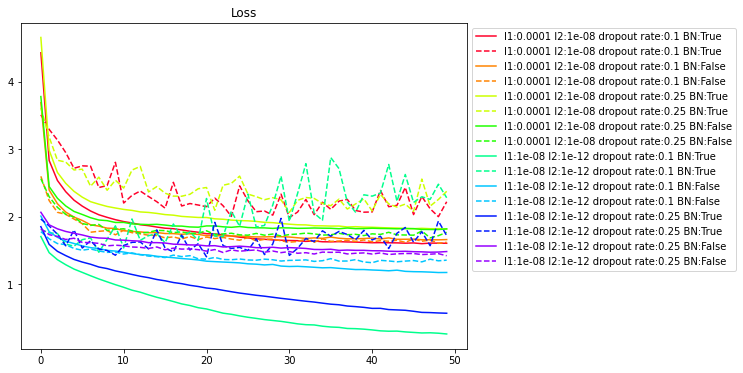

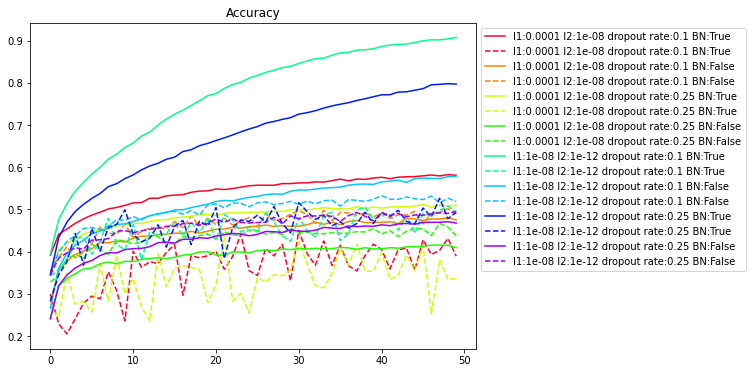

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()